In [ ]:
import numpy as np

## MNIST

In [ ]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [ ]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [ ]:
mnist

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array([0, 0, 0, ..., 9, 9, 9], dtype=int8),
 'frame': None,
 'categories': {},
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixel49',
  'pixel

In [ ]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [ ]:
%matplotlib inline               
import matplotlib as mpl
import matplotlib.pyplot as plt

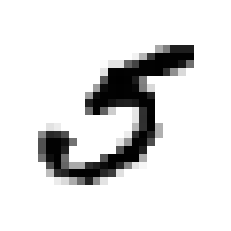

In [ ]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")   # imshow: 이미지 보여주기
                                                                                     # binary color map을 사용해 그림
                                                                                     # nearest: 새로운 지점 또는 한 지점 값을 결정할 때 주변 분포한 값을 사용해 결정하는 것
plt.axis("off")
plt.show()

In [ ]:
y[36000]

5

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
shuffle_index = np.random.permutation(60000)                        # 훈련 데이터를 랜덤으로 섞음
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier

In [ ]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [ ]:
from sklearn.linear_model import SGDClassifier #StochasticGradientDescent

sgd_clf = SGDClassifier(loss='hinge', max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(max_iter=5, random_state=42, tol=-inf)

#### SGD: 큰 dataset을 다루는 데 효과적임

In [ ]:
sgd_clf.predict([some_digit])   # 예측 성공: True, 예측 실패: False

array([ True])

## Measuring Accuracy Using Cross-Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold                   # k-fold 교차검증
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95235
0.9631
0.95515


In [ ]:
from sklearn.model_selection import cross_val_score   # k-fold 교차검증

cross_val_score(estimator = sgd_clf, X=X_train, y=y_train_5, cv=3, scoring="accuracy")   # cv: 검증 fold 수 (default:3)

array([0.95605, 0.969  , 0.96005])

In [ ]:
from sklearn.base import BaseEstimator            # 5가 아닌 정수들의 분류 정확성 계산
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()                                            # 5가 전체의 10%를 차지하기 때문에 5-나머지는 90%의 정확성을 가짐
                                                                            # skewed data에서 accuracy는 선호되지 않음
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9092 , 0.9092 , 0.91055])

## Confusion Matrix

In [ ]:
from sklearn.model_selection import cross_val_predict               # 오차행렬 만들기: 클래스 A의 샘플이 B로 분류된 횟수를 세어 행렬로 나타낸 것
                                                                     # ex) 숫자 1 이미지가 2로 분류된 횟수를 알고 싶으면 1행 2열을 보면 됨

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)   # 실제 타깃(y_train_5)과 비교할 예측값 생성
                                                                      # cross_val_score는 평가 결과 점수를 반영 vs cross_val_predict는 각 테스트 케이스의 결과를 반영

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)       # y_train_5: 원래 정답, y_train_pred: 모델이 분류한 정답

array([[53256,  1323],
       [  975,  4446]], dtype=int64)

##### array([[5 아닌데 5 아니라고 잘 분류한 횟수(TN), 5 아닌데 5라고 잘못 분류한 횟수(FP)],
#####           [5맞는데 5 아니라고 잘못 분류한 횟수(FN), 5 맞는데 5라고 잘 분류한 횟수(TP)]])

In [ ]:
from sklearn import metrics

print(metrics.classification_report(y_train_5, y_train_pred))

              precision    recall  f1-score   support

       False       0.98      0.98      0.98     54579
        True       0.77      0.82      0.79      5421

    accuracy                           0.96     60000
   macro avg       0.88      0.90      0.89     60000
weighted avg       0.96      0.96      0.96     60000



## Precision and Recall

#### precision=TP/(TP+FP)
#### recall=TP/(TP+FN)

In [ ]:
from sklearn.metrics import precision_score, recall_score   # precision: FP가 0에 가까울수록 정확도 높음, recall: FN이 0에 가까울수록 정확도 높음
print(precision_score(y_train_5, y_train_pred))              # 정밀도 출력
print(recall_score(y_train_5, y_train_pred))                 # 재현율 출력

0.7706708268330733
0.8201438848920863


In [ ]:
from sklearn.metrics import f1_score   # F1=TP*(TP+((FN+FP)/2))
f1_score(y_train_5, y_train_pred)

0.7946380697050939

## Precision/Recall Tradeoff

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])   # some_digit에서의 score
y_scores

array([8102.06256169])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [ ]:
threshold = 200000                           # threshold 증가시키니 recall 감소. 5를 감지하지 못함
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

#### threshold를 어느 정도 수준에서 결정해야할까?

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")   # cross_val_predict() 함수를 사용해 모든 경우에서의 score 구함(decision_function)

In [ ]:
from sklearn.metrics import precision_recall_curve   
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)   # 구한 score들을 가지고 precision과 recall을 계산

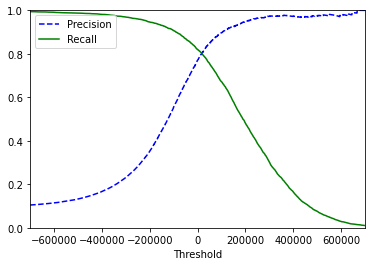

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

#### trade-off 관계를 보여줌

In [ ]:
y_train_pred_90 = (y_scores > 70000)   # 90%의 precision을 aim하기 위해

In [ ]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.8708027573938181
0.7223759453975281


## The ROC Curve

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

#### TPR: true positive rate(=recall)
#### FPR: false positive rate(=positive로 잘못 분류된 negative의 비율) 

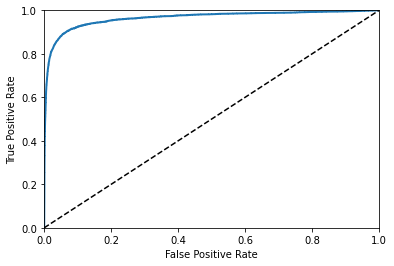

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):       
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

#### TPR과 FPR 역시 trade off 관계를 가짐

#### 점선은 ROC: purely random classifier

#### 좋은 classifier는 ROC와 가능한 가장 멀리 떨어짐 (왼쪽 상단으로)

In [ ]:
from sklearn.metrics import roc_auc_score   # area under curve를 사용해 classifer를 비교
                                             # ROC 위의 ROC AUC 값은 0.5
                                             # 완벽한 classifier의 ROC AUC 값은 1
roc_auc_score(y_train_5, y_scores)

0.9647671382954184

#### RandomForestClassifier를 train하고 이것의 ROC 곡선과 ROC AUC score를 SGDClassfier과 비교

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")   # RandomForestClassifier는 decision_function()이 없기 때문에 predict_proba()를 사용해 score를 구함

#### - predict_proba()는 row(instance)Xcolumn(class)의 각 원소는 주어진 class에 대한 instance의 확률을 갖는 array를 반환

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class (array의 원소가 확률값이므로 대체해준다)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

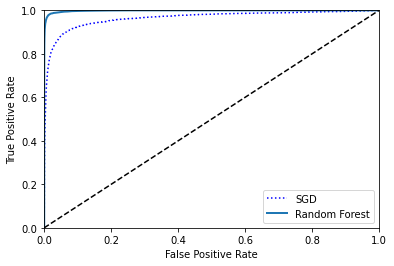

In [ ]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

#### SGD보다 더 나은 곡선이 그려짐

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)   # ROC AUC 값도 더 높음

0.9984415631856125

## Multiclass Classification

In [ ]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit]) # predict 값이 틀린 값이 나옴...(?)

array([0], dtype=int8)

In [ ]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores   # 0에서 가장 큰 score가 나옴....(?)

array([[  37318.19716685, -582619.72528075, -464300.45846766,
        -180405.29032719, -666011.99211967,  -60485.04648071,
        -591183.78472499, -420243.1165342 , -798182.30773594,
        -602899.60224277]])

In [ ]:
print(np.argmax(some_digit_scores))
print(sgd_clf.classes_)
print(sgd_clf.classes_[5])

0
[0 1 2 3 4 5 6 7 8 9]
5


In [ ]:
from sklearn.multiclass import OneVsOneClassifier   # one vs one classifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

[5]
45


In [ ]:
forest_clf.fit(X_train, y_train)   # RandomForestClassifier를 train
forest_clf.predict([some_digit])

array([5], dtype=int8)

#### RandomForestClassifier는 직접 instance들을 classes로 분류하기 때문에 Scikit-Learn은 OvA나 OvO를 할 필요 없음

In [ ]:
forest_clf.predict_proba([some_digit])   # model이 이미지가 5를 나타냄을 93%로 추정함

array([[0.  , 0.  , 0.02, 0.02, 0.  , 0.93, 0.01, 0.  , 0.01, 0.01]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")   #cross-validation 사용해 SGD분류를 평가

array([0.8765 , 0.8654 , 0.87255])

In [ ]:
from sklearn.preprocessing import StandardScaler   #자료를 표준화할 경우 정확성 더 오름
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.9094 , 0.91045, 0.9088 ])

## Error Analysis

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)   # predict
conf_mx = confusion_matrix(y_train, y_train_pred)                          # confusion_matrix
conf_mx

array([[5731,    2,   22,    8,    9,   48,   45,   10,   41,    7],
       [   2, 6498,   42,   25,    5,   39,    9,    9,   99,   14],
       [  56,   38, 5347,   96,   76,   24,   80,   56,  171,   14],
       [  48,   40,  140, 5328,    2,  240,   33,   55,  142,  103],
       [  21,   25,   42,   11, 5353,   10,   57,   36,   83,  204],
       [  73,   42,   33,  189,   66, 4606,  112,   25,  180,   95],
       [  41,   24,   52,    3,   36,   88, 5619,   10,   44,    1],
       [  25,   21,   73,   25,   53,   11,    5, 5792,   15,  245],
       [  55,  154,   71,  141,   13,  163,   60,   27, 5022,  145],
       [  42,   33,   27,   81,  163,   28,    3,  207,   88, 5277]],
      dtype=int64)

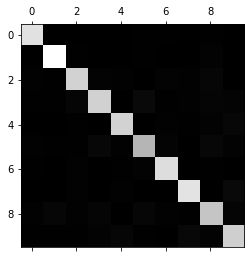

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)   # 보기 어려우므로 이미지로 봄
plt.show()

#### diagonal에 대부분의 이미지가 몰려 있음. 분류가 잘 되었음
#### 5번째 대각원소가 가장 어두움. 다른 정수에 비해 5에서 분류 성과가 저조

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums               # error rate로 비교

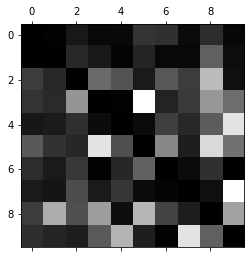

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)             # 대각열은 0으로 넣고 error rate 확인
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

#### 8, 9열의 색이 밝으므로 misclassified 됐을 가능성 높음
#### 8, 9행의 색이 밝으므로 8과 9는 종종 다른 정수들과 혼돈됨을 예상할 수 있음

#### 1은 매우 어두움. 분류 잘 됨
#### 그림이 symmetric하지 않음

#### => 8과 9에 대한 분류 향상을 위한 노력 필요

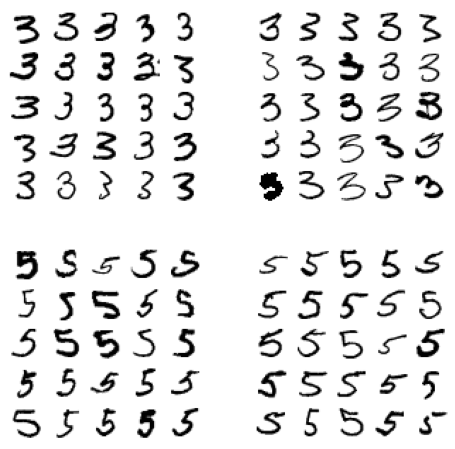

In [ ]:
cl_a, cl_b = 3, 5                                            # 각각의 error 확인하기 위해 3과 5의 digit 확인해봄
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)                       # 숫자가 7보다 큰지
y_train_odd = (y_train % 2 == 1)                     # 홀수인지
y_multilabel = np.c_[y_train_large, y_train_odd]     # 둘 다

knn_clf = KNeighborsClassifier()                     # multilabel classification 지원
knn_clf.fit(X_train, y_multilabel)                   # train

KNeighborsClassifier()

In [ ]:
 knn_clf.predict([some_digit])   # 5는 0보다 크지 않고(Fasle) 홀수임(True)

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)   # evaluate(F1 score)
f1_score(y_train, y_train_knn_pred, average="macro")

## Multioutput Classification

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)